In [1]:
import sys
import numpy as np
import xarray as xr
import datetime
import scipy.stats as spy
import random

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import pickle 

In [2]:
sys.path.append("../../")
import Online_DA_utils as oda

In [3]:
import importlib
importlib.reload(oda)

<module 'Online_DA_utils' from '../../Online_DA_utils.py'>

In [4]:
t =0
# Select number of years to reconstruct: 
nyears = 155

# Generate times: 
t_total = nyears*12
years = int(1851+np.floor((t_total-1)/12))
time = np.array([datetime.datetime(y, m, 15) for y in np.arange(1851,1851+nyears,1) for m in np.arange(1,13,1)])

limvars = ['tas','psl','zg','tos','sit','sic']
neofs = 300
Nobs = 100

In [5]:
tname = 'cesm_lme_Amon'
limname = 'cesm_lme_Amon'
modname = 'cesm_lme_Amon'
tname = 'cesm_lme_Amon'
obsname = 'cesm_lme_Amon'
# obsname = 'cesm_lme_Amon'

In [6]:
## ---------------------------------------------------------
## LOAD L: 
## ---------------------------------------------------------
print('Loading L....')
LIM = oda.load_L(limname)
LIMd = LIM['LIMd']
#LIMd.keys()

Projector_tas = LIMd['E3']['tas']

Loading L....
Loading: /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/master/LIMcast_cesm_lme_Amon_ntrain_850_1650_cesm_lme_Amon_validy_1651_1850_tas50L0.1_psl50L0.1_zg50L0.1_tos50L0.1_sit50L40_sic50L40_20211202_sqrtWt.pkl


In [7]:
## ---------------------------------------------------------
## LOAD Pseudo Obs: 
## ---------------------------------------------------------
obsdir = '/home/disk/p/mkb22/Documents/si_analysis_kb/Online_DA_monthly/observations/'
#obsfilename = 'TAS_pseudo_obs_'+obsname+'_1851_2005.pkl'
#obsfilename = 'Hadcrut_data_on_CESMLME_grid_NH.pkl'
obsfilename = 'TAS_pseudo_obs_'+obsname+'_hadCRUT_locations_1851_2005.pkl'

had_obs_data = pickle.load(open(obsdir+obsfilename,"rb"))

#had_obs_data_full = had_obs_data['had_on_refgrid'][12:1872,:,:]
had_obs_data_full = had_obs_data['observations']

#Select obs mask from given timestep in Hadcrut to use throughout:
# had_155_mask = np.where(np.isfinite(had_obs_data_og[:,:,150]),1,0)
# had_obs_data_full = had_155_mask[:,:,np.newaxis]*np.nan_to_num(had_obs_data_og[:,:,:])
# had_obs_data_full[np.logical_not(np.abs(had_obs_data_full)>0)]=np.nan

had_obs_full_2d = np.reshape(had_obs_data_full, (had_obs_data_full.shape[0]*had_obs_data_full.shape[1],
                                                had_obs_data_full.shape[2]))
# had_obs_full_2d = np.reshape(had_obs_data_full, (had_obs_data_full.shape[0],
#                                                  had_obs_data_full.shape[1]*had_obs_data_full.shape[2])).T

# Project HadCRUT to eof space:
eofs_out = LIMd['E3']['tas']/LIMd['standard_factor']['tas']
P_var = np.matmul(eofs_out.T, (LIMd['W_all']['tas'][:,np.newaxis]*np.nan_to_num(had_obs_full_2d)))
Ptrunc = P_var/LIMd['standard_factor']['tas']

In [8]:
## ---------------------------------------------------------
## LOAD INITIAL CONDITIONS IN EOF SPACE: 
## ---------------------------------------------------------
priordir = '/home/disk/p/mkb22/Documents/si_analysis_kb/Online_DA_monthly/priors/'
priorname = 'Xb_initial_'+modname+'_300ndof_1651_1850.pkl'
trainname = 'Xb_initial_'+modname+'_300ndof_850_1650.pkl'
#trainname = 'Xb_initial_'+tname+'_300ndof_1850_2473.pkl'

Xb_initial_data = pickle.load(open(priordir+priorname,"rb"))
Xb_initial_allt = Xb_initial_data['Xb_initial']

Xb_train_data = pickle.load(open(priordir+trainname,"rb"))
Xb_train_allt = Xb_train_data['Xb_initial']

ndof_total = 0
limvars = ['tas','psl','zg','tos','sit','sic']
for var in limvars: 
    ndof_total = ndof_total+LIMd['var_dict'][var]['var_ndof']
    
Pb_initial = LIMd['C_0']

In [9]:
## ---------------------------------------------------------
## BUILD H: 
## ---------------------------------------------------------
#had_mask = np.zeros_like(had_obs_data_full)
#had_mask[np.isfinite(had_obs_data_full)] = had_mask[np.isfinite(had_obs_data_full)]+1

## Randomly sample X number of obs at each timestep: 
had_mask_rand = np.zeros_like((had_obs_full_2d.T))

for t in range(1860):
    true_inds = np.where(np.isfinite(np.reshape(had_obs_data_full[:,:,t],
                                                (had_obs_data_full.shape[1]*had_obs_data_full.shape[0]))))
    
    if true_inds[0].shape[0]>=Nobs:
        true_rand = random.sample(list(true_inds[0]),Nobs)
    else: 
        true_rand = true_inds[0]

    had_mask_rand[t,true_rand] = had_mask_rand[t,true_rand]+1
    
had_mask = np.reshape(had_mask_rand,(had_mask_rand.shape[0],had_obs_data_full.shape[0],
                                       had_obs_data_full.shape[1]))

In [10]:

E3_all = np.zeros((ndof_total,neofs))
ntrunc = 50

for v,var in enumerate(limvars): 
    E3_all[LIMd['var_dict'][var]['var_inds'],
           int(v*ntrunc):int((v+1)*ntrunc)] = LIMd['E3'][var]/np.sqrt(LIMd['standard_factor'][var])


In [11]:
## ---------------------------------------------------------
## Initialize loop over time: 
## ---------------------------------------------------------
obs_assimilated = {}
Xa_alltime = np.zeros((t_total,neofs))
diff_alltime = {}
K_den_alltime = {}
mse_xb = np.zeros((t_total))
mse_xa = np.zeros((t_total))
Pb_trace = np.zeros((t_total))
ratios = {}

Xb = np.nan_to_num(Xb_initial_allt[:,-1])
Pb = Pb_initial

In [12]:
t = 100 

if (t%100==0)&(t!=0):
    print('yes')

yes


In [13]:
t=0

In [14]:
## ---------------------------------------------------------
## BUILD H: 
## ---------------------------------------------------------
#    H_cap, nobs, ndof = oda.build_H_time(had_mask[:,:,t])
H_cap, nobs, ndof = oda.build_H_time(had_mask[t,:,:])

H = np.zeros((nobs,ndof_total))
H[:,0:6912] = H_cap

U = E3_all
H_eof = np.matmul(H,U)

In [15]:
## ---------------------------------------------------------
## BUILD R: 
## ---------------------------------------------------------
Hx = np.matmul(H_eof,Xb_train_allt[:,-had_obs_full_2d.shape[1]:])
Hx_cap = np.matmul(H_cap,np.nan_to_num(had_obs_full_2d))

epsilon = Hx_cap - Hx

slope = np.zeros(Hx.shape[0])
for i in range(Hx.shape[0]):
    slope[i],_,_,_,_ = spy.linregress(Hx[i,:],epsilon[i,:])
e = epsilon - slope[:,np.newaxis]*Hx

R = np.matmul(epsilon,epsilon.T)/(epsilon.shape[1]-1)
R_e = np.matmul(e,e.T)/(e.shape[1]-1)

Text(0, 0.5, 'epsilon')

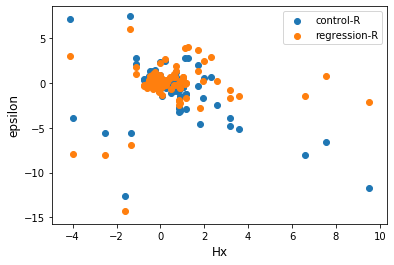

In [16]:
t = 1500
plt.scatter(Hx[:,t],epsilon[:,t],label='control-R')
plt.scatter(Hx[:,t],e[:,t],label='regression-R')
plt.legend()
plt.xlabel('Hx',fontsize=12)
plt.ylabel('epsilon',fontsize=12)

In [17]:
R_hack = R_e
H_final = H_eof

#Y = np.matmul(H_cap,np.nan_to_num(had_obs_full_2d[:,t]))
Y = np.matmul(H_cap,np.nan_to_num(had_obs_full_2d[:,t]))+(np.sqrt(r)*np.random.randn(Nobs))

obs = {}
obs['obs'] = Y
#     obs['obs_lat'] = obs_lat
#     obs['obs_lon'] = obs_lon
obs_assimilated[t] = obs

NameError: name 'r' is not defined

In [ ]:
(np.sqrt(r)*np.random.randn(Nobs)).shape, np.matmul(H_cap,np.nan_to_num(had_obs_full_2d[:,t])).shape

In [57]:
print('Solving update equation....')
print('Updating mean state.')
print('Nobs assimilated = '+str(Y.shape[0])) 

Xa, K, K_den, diff = oda.solver_KF_update(Xb, Pb, Y, R_hack, H_final)
    
Xa_alltime[t,:] = Xa
mse_xb[t] = np.nanmean(diff**2)
mse_xa[t] = np.nanmean((Y - np.matmul(H_final,Xa))**2)
diff_alltime[t] = diff 
K_den_alltime[t] = K_den
cov_d = np.matmul(diff[:,np.newaxis],diff[np.newaxis,:])
ratio = np.diagonal(cov_d)/np.diagonal(K_den)

print('Prior MSE     = '+str(mse_xb[t]))
print('Posterior MSE = '+str(mse_xa[t]))
print('median(ratio) = '+str(np.median(ratio)))
print('mean(ratio) = '+str(np.mean(ratio)))

Solving update equation....
Updating mean state.
Nobs assimilated = 55
Prior MSE     = 11.4051333578553
Posterior MSE = 1.9243608902414904
median(ratio) = 0.19291934233891814
mean(ratio) = 0.8959521046331372


In [58]:
diff.shape

(55,)

In [71]:
ndof = Pb.shape[0]

print('Updating covariance.')

Pa = oda.solver_KF_cov(K,H_final,Pb)
#    Pa_inf = Pa*1.5

Updating covariance.


In [72]:
Pa.shape

(300, 300)

In [83]:
print('Performing forecast...')
LIM_Xfcast = oda.LIM_forecast(LIMd,Xa,Pa,1,adjust=False)

Xb = LIM_Xfcast['x_forecast']
Pb = LIM_Xfcast['cov_forecast']

Pb_trace[t] = np.trace(LIM_Xfcast['cov_forecast'])

print('R = '+str(R_hack.max()))
print('HPbHT = '+str(np.max(np.matmul(np.matmul(H_final,Pb),H_final.T))))

Performing forecast...
Adjust is False...
lag= 1
R = 12.302818894226164
HPbHT = 13.82178224821778


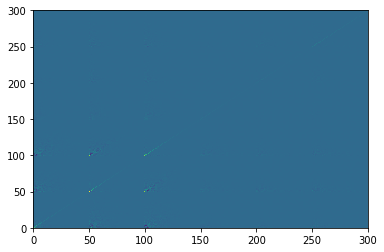

In [88]:
plt.pcolormesh(np.real(N))

In [85]:
eig,vals = np.linalg.eig(N)

In [86]:
np.log(eig)

array([ -1.06509812-1.05244987e-14j,  -1.45507611+8.60802343e-16j,
        -1.58056824-4.52067598e-15j,  -1.72027912-3.07804678e-15j,
        -2.05238452+1.60032383e-15j,  -2.12812062-1.00373720e-14j,
        -2.16242855+1.42826851e-16j,  -2.33327086-3.79498397e-15j,
        -2.53475076-9.33433156e-15j,  -2.54455614+2.11657678e-16j,
        -2.7997739 -5.73675946e-15j,  -3.02425636-1.29899907e-15j,
        -3.19538056+7.85562388e-16j,  -3.25863266+3.03138226e-15j,
        -3.31750054-1.69264665e-14j,  -3.31260372-2.68068171e-15j,
        -3.49286198-9.07844069e-16j,  -3.56210698+3.75555086e-16j,
        -3.58993926-4.16916012e-15j,  -3.66348601-3.44724269e-15j,
        -3.70865116-5.50092103e-15j,  -3.80103478-2.30422368e-14j,
        -3.82101894+3.20719701e-15j,  -3.90158142+1.55298494e-15j,
        -3.9400652 +3.28626087e-16j,  -3.93781717-2.57421324e-14j,
        -3.97546288+3.41566402e-15j,  -4.03196711-2.95871115e-15j,
        -4.06109356+1.02997452e-14j,  -4.12633604-1.27359872e-

In [23]:
obsdir = '/home/disk/p/mkb22/Documents/si_analysis_kb/Online_DA_monthly/observations/'
#obsfilename = 'TAS_pseudo_obs_'+obsname+'_1851_2005.pkl'
obsfilename = 'Hadcrut_data_on_CESMLME_grid_NH.pkl'
#obsfilename = 'TAS_pseudo_obs_'+obsname+'_hadCRUT_locations_1851_2005.pkl'

had_obs_data = pickle.load(open(obsdir+obsfilename,"rb"))

#had_obs_data_full = had_obs_data['had_on_refgrid'][12:1872,:,:]
had_obs_data_full = had_obs_data['had_on_refgrid'][12:2063,:,:]
#had_obs_data_full = had_obs_data['observations']
# had_obs_data_og = had_obs_data['observations']

#Select obs mask from given timestep in Hadcrut to use throughout:
# had_155_mask = np.where(np.isfinite(had_obs_data_og[:,:,150]),1,0)
# had_obs_data_full = had_155_mask[:,:,np.newaxis]*np.nan_to_num(had_obs_data_og[:,:,:])
# had_obs_data_full[np.logical_not(np.abs(had_obs_data_full)>0)]=np.nan

# had_obs_full_2d = np.reshape(had_obs_data_full, (had_obs_data_full.shape[0]*had_obs_data_full.shape[1],
#                                                 had_obs_data_full.shape[2]))
had_obs_full_2d = np.reshape(had_obs_data_full, (had_obs_data_full.shape[0],
                                                 had_obs_data_full.shape[1]*had_obs_data_full.shape[2])).T

In [61]:
t = 1860

In [62]:
## Randomly sample X number of obs at each timestep: 
had_mask_rand = np.zeros_like((had_obs_full_2d.T))

for t in range(1860):
    true_inds = np.where(np.isfinite(np.reshape(had_obs_data_full[t,:,:],
                                                (had_obs_data_full.shape[1]*had_obs_data_full.shape[2]))))

    if true_inds[0].shape[0]>=Nobs:
        true_rand = random.sample(list(true_inds[0]),Nobs)
    else: 
        true_rand = true_inds[0]

    had_mask_rand[t,true_rand] = had_mask_rand[t,true_rand]+1

had_mask = np.reshape(had_mask_rand,(had_mask_rand.shape[0],had_obs_data_full.shape[1],
                                     had_obs_data_full.shape[2]))

IndexError: index 65988 is out of bounds for axis 1 with size 6912

In [63]:
had_mask.shape

(1860, 48, 144)

In [27]:
H_cap, nobs, ndof = oda.build_H_time(had_mask[t,:,:])

H = np.zeros((nobs,ndof_total))
H[:,0:6912] = H_cap

In [28]:
H_cap.shape

(50, 6912)

In [60]:
Y = np.matmul(H_cap,np.nan_to_num(had_obs_full_2d[:,t]))
Y.shape

(55,)